In [2]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from joblib import dump, load
from analysis.offsets import offsets

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/more_results/gmms/")

%matplotlib inline

In [3]:
subjects = analysis.load_subjects()

In [4]:
import pandas as pd
trajectory_df = pd.read_pickle("../trajectory_dataframe.pkl")
mean_rewards = 1 / trajectory_df.groupby(level=['subject']).mean()["reward"]

## model subspace confinement -- over time

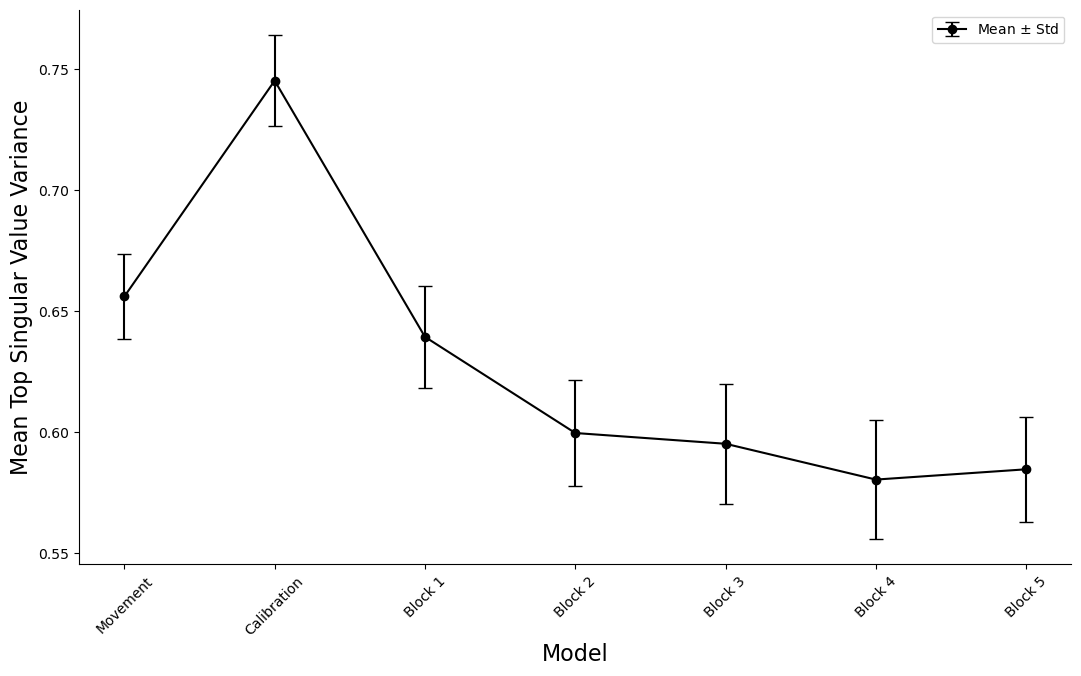

In [30]:
# fig,axes = plt.subplots(1,7,figsize=(40,6))
# for ax in axes:
#     ax.set_xlim([0,1])

grand_means = []
grand_sds = []

n_sing_vals = 2

# subjects, model, component, singular vals
s = np.zeros(shape=(46,12))
for subject_idx in range(len(subjects)):
    for i, m in enumerate(model.load_log_movement_models(subject_idx)):
        # each model over time
        for k, cov in enumerate(m.covariances_):
            # svd of each of the 4 components
            U, S, V = np.linalg.svd(cov)
            s[subject_idx,k] = (S[:n_sing_vals]/S.sum()).reshape(-1)[0]            
mean_sv = np.mean(s,axis=(1))
grand_means.append(np.mean(mean_sv))
grand_sds.append(np.std(mean_sv))
# axes[1].hist(mean_sv,alpha=0.5,density=True,bins=5)

# subjects, model, component, singular vals
s = np.zeros(shape=(46,12))
for subject_idx in range(len(subjects)):
    for i, m in enumerate(model.load_log_calibration_models(subject_idx)):
        # each model over time
        for k, cov in enumerate(m.covariances_):
            # svd of each of the 4 components
            U, S, V = np.linalg.svd(cov)
            s[subject_idx,k] = (S[:n_sing_vals]/S.sum()).reshape(-1)[0]            
mean_sv = np.mean(s,axis=(1))
grand_means.append(np.mean(mean_sv))
grand_sds.append(np.std(mean_sv))
# axes[0].hist(mean_sv,alpha=0.5,density=True,bins=5)

# subjects, model, component, singular vals
for model_idx in range(5):
    s = np.zeros(shape=(46,12))
    for subject_idx in range(len(subjects)):
        m = model.load_log_trial_models(subject_idx)[model_idx]
        # each model over time
        for k, cov in enumerate(m.covariances_):
            # svd of each of the 4 components
            U, S, V = np.linalg.svd(cov)
            s[subject_idx,k] = (S[:n_sing_vals]/S.sum()).reshape(-1)[0]
    mean_sv = np.mean(s,axis=(1))
    grand_means.append(np.mean(mean_sv))
    grand_sds.append(np.std(mean_sv))
    # axes[model_idx+2].hist(mean_sv,alpha=0.5,density=True,bins=5)

rank_fig = plt.figure()
plt.errorbar(list(range(7)),grand_means,yerr=grand_sds/np.sqrt(12),color="k",capsize=5,linestyle="-",marker="o",label=f"Mean $\pm$ Std")
plt.ylabel("Mean Top Singular Value Variance")
plt.xlabel("Model")
plt.legend()

xlabels = ["Movement","Calibration","Block 1","Block 2","Block 3","Block 4","Block 5"]
_ = plt.xticks(ticks=range(7),labels=xlabels,rotation=45)

In [31]:
plot.save_figure(rank_fig, "gmm_rank", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/gmm_rank.pdf


## subspace confinement of calib vs. reward

/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_22045/274758353.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s[subject_idx,i,k] = (S[:n_sing_vals].sum()/S.sum()).reshape(-1)


0.7656395867558637


/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_22045/274758353.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s[subject_idx,i,k] = (S[:n_sing_vals].sum()/S.sum()).reshape(-1)


0.014140347140742518


/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_22045/274758353.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s[subject_idx,i,k] = (S[:n_sing_vals].sum()/S.sum()).reshape(-1)


1.890291893335791e-06


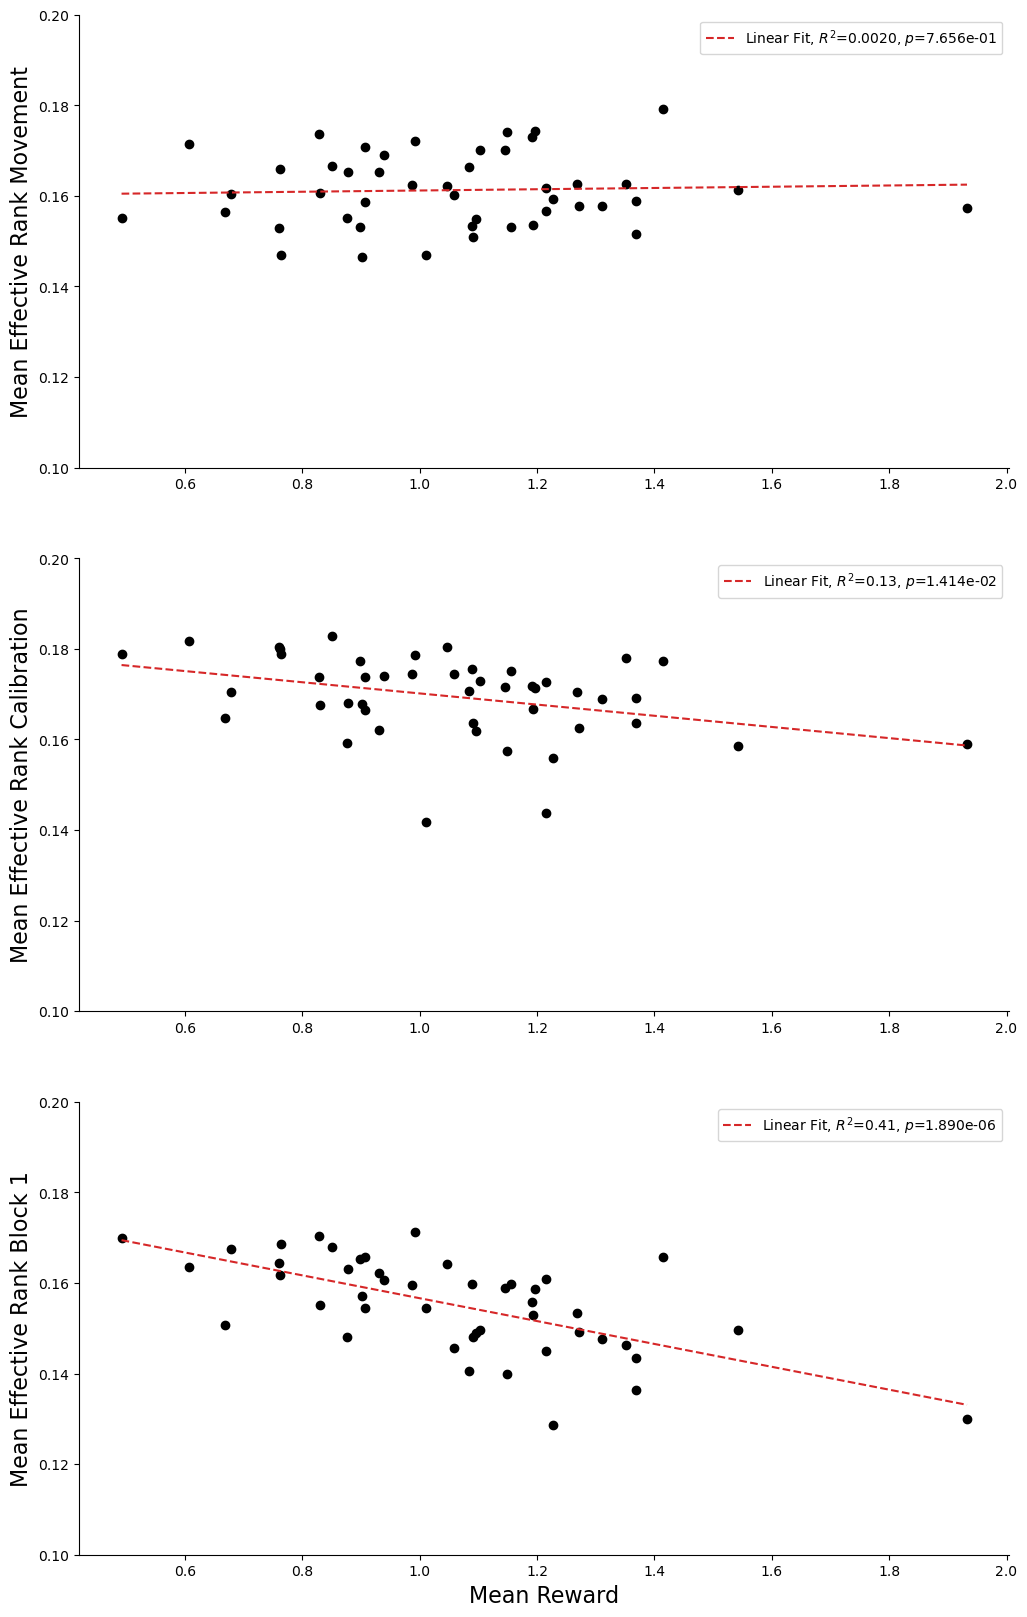

In [16]:
# subjects, model, component, singular vals
fig, axes = plt.subplots(3,1,figsize=(12,20))
# fig.tight_layout()

# subjects, model, component, singular vals
n_sing_vals = 2
s = np.zeros(shape=(46,5,12))
for subject_idx in range(len(subjects)):
    for i, m in enumerate(model.load_log_movement_models(subject_idx)):
        # each model over time
        for k, cov in enumerate(m.covariances_):
            # svd of each of the 4 components
            U, S, V = np.linalg.svd(cov)
            s[subject_idx,i,k] = (S[:n_sing_vals].sum()/S.sum()).reshape(-1)

mean_sv_move = np.mean(s,axis=(1,2))
axes[0].plot(mean_rewards,mean_sv_move,'ko')
res = analysis.linear_fit(mean_rewards, mean_sv_move)
x = np.linspace(mean_rewards.min(),mean_rewards.max(),100)
plot.plot_linear_fit(x, res, axes[0])
axes[0].legend()
axes[0].set_ylabel("Mean Effective Rank Movement")
# axes[0].set_xlabel("Mean Reward")
axes[0].set_ylim([0.1,0.2])
print(res.pvalue)

n_sing_vals = 2
s = np.zeros(shape=(46,5,12))
for subject_idx in range(len(subjects)):
    for i, m in enumerate(model.load_log_calibration_models(subject_idx)):
        # each model over time
        for k, cov in enumerate(m.covariances_):
            # svd of each of the 4 components
            U, S, V = np.linalg.svd(cov)
            s[subject_idx,i,k] = (S[:n_sing_vals].sum()/S.sum()).reshape(-1)

mean_sv_calib = np.mean(s,axis=(1,2))
axes[1].plot(mean_rewards,mean_sv_calib,'ko')
res = analysis.linear_fit(mean_rewards, mean_sv_calib)
x = np.linspace(mean_rewards.min(),mean_rewards.max(),100)
plot.plot_linear_fit(x, res, axes[1])
axes[1].legend()
axes[1].set_ylabel("Mean Effective Rank Calibration")
# axes[1].set_xlabel("Mean Reward")
axes[1].set_ylim([0.1,0.2])
print(res.pvalue)

n_sing_vals = 2
s = np.zeros(shape=(46,5,12))
for subject_idx in range(len(subjects)):
    for i, m in enumerate(model.load_log_trial_models(subject_idx)[:1]):
        # each model over time
        for k, cov in enumerate(m.covariances_):
            # svd of each of the 4 components
            U, S, V = np.linalg.svd(cov)
            s[subject_idx,i,k] = (S[:n_sing_vals].sum()/S.sum()).reshape(-1)

mean_sv_calib = np.mean(s,axis=(1,2))
axes[2].plot(mean_rewards,mean_sv_calib,'ko')
res = analysis.linear_fit(mean_rewards, mean_sv_calib)
x = np.linspace(mean_rewards.min(),mean_rewards.max(),100)
plot.plot_linear_fit(x, res, axes[2])
axes[2].legend()
axes[2].set_ylabel("Mean Effective Rank Block 1")
axes[2].set_xlabel("Mean Reward")
axes[2].set_ylim([0.1,0.2])
print(res.pvalue)

In [17]:
plot.save_figure(fig, "rank_vs_reward", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/rank_vs_reward.pdf


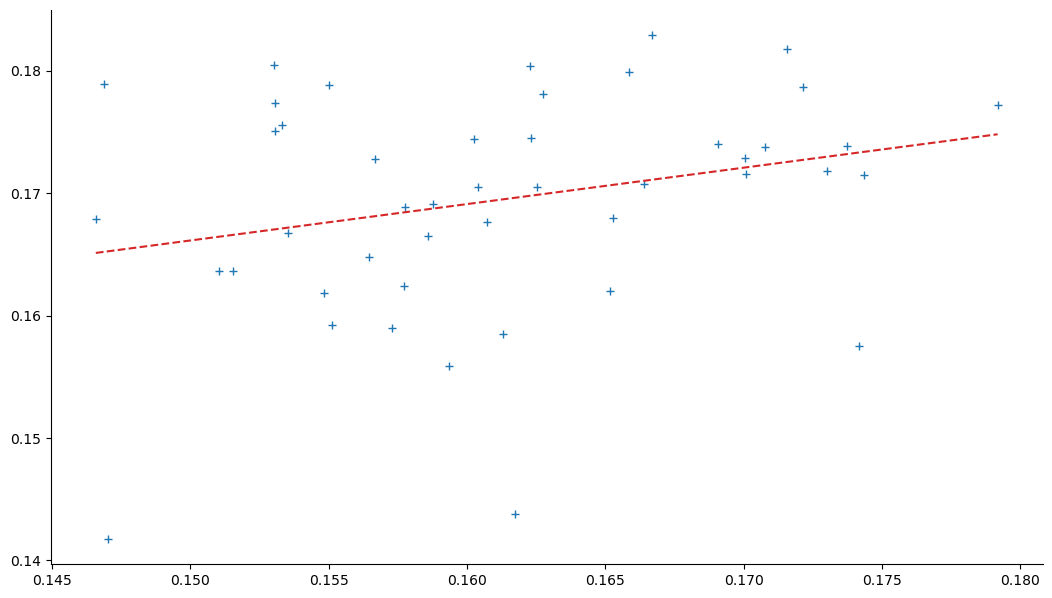

In [43]:
plt.plot(mean_sv_move,mean_sv_calib)
res = analysis.linear_fit(mean_sv_move, mean_sv_calib)
x = np.linspace(mean_sv_move.min(),mean_sv_move.max(),100)
plot.plot_linear_fit(x, res, plt.gca())